# Applied Project: Topic 3

# Group 16: Joaquin Negrete, Pablo Suárez


# Preproccesing


We will first import the data. Reviewing the data in the csv, we can see that the string data has a space at the start. We will trim that.


In [1]:
import pandas as pd
import numpy as np

from copy import deepcopy

from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler

from matplotlib import pyplot as plt

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

In [ ]:
try:
    data = pd.read_csv("/content/drive/MyDrive/data-even.csv")
except FileNotFoundError:
    data = pd.read_csv("./data-even.csv")
data[["Education", "MaritalStatus", "Relationship", "Gender"]] = data[["Education", "MaritalStatus", "Relationship", "Gender"]].map(lambda x: x.strip())
data.head(10)

Age     Education  EducationNum       MaritalStatus   Relationship  Gender  \
0   39     Bachelors            13       Never-married  Not-in-family    Male   
1   50     Bachelors            13  Married-civ-spouse        Husband    Male   
2   52       HS-grad             9  Married-civ-spouse        Husband    Male   
3   30     Bachelors            13  Married-civ-spouse        Husband    Male   
4   25       HS-grad             9       Never-married      Own-child    Male   
5   43       Masters            14            Divorced      Unmarried  Female   
6   35           9th             5  Married-civ-spouse        Husband    Male   
7   56     Bachelors            13  Married-civ-spouse        Husband    Male   
8   54  Some-college            10  Married-civ-spouse        Husband    Male   
9   23    Assoc-acdm            12       Never-married  Not-in-family    Male   

   CapitalGain  HoursPerWeek  
0         2174            40  
1            0            13  
2            0            45  
3            0            40  
4            0            35  
5            0            45  
6            0            40  
7            0            40  
8            0            60  
9            0            52

## Data characteristics


In [3]:
data.dtypes

Age               int64
Education        object
EducationNum      int64
MaritalStatus    object
Relationship     object
Gender           object
CapitalGain       int64
HoursPerWeek      int64
dtype: object

In [4]:
# Rows x columns
data.shape

(9865, 8)

In [5]:
# Count row numbers with missing data per column
missing_data_count = data.isnull().sum()
print("Number of rows with missing data per column:")
print(missing_data_count)

# Count the total number of rows with at least one missing column
total_missing_rows = data.isnull().any(axis=1).sum()
print("\nTotal number of rows with at least one value missing:", total_missing_rows)

Number of rows with missing data per column:
Age              0
Education        0
EducationNum     0
MaritalStatus    0
Relationship     0
Gender           0
CapitalGain      0
HoursPerWeek     0
dtype: int64

Total number of rows with at least one value missing: 0


In [6]:
# Count the number of duplicated rows
dups = data[data.duplicated()]
print(f"Number of duplicated rows: {len(dups)}")

Number of duplicated rows: 2810


In [7]:
# Remove the dups
data = data.drop_duplicates()

data.shape

(7055, 8)

Lets check how is numerical data distributed


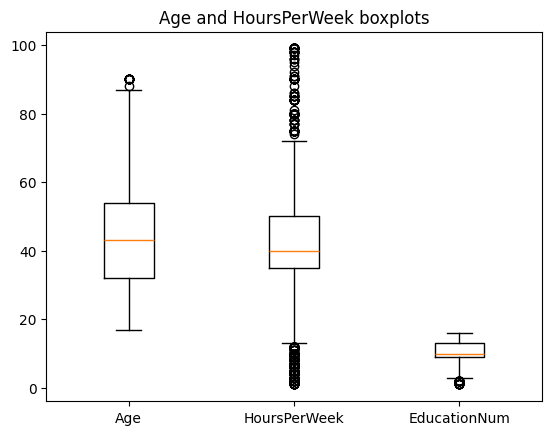

In [8]:
plt.figure(1)
plt.boxplot(data[["Age", "HoursPerWeek", "EducationNum"]], tick_labels=["Age", "HoursPerWeek", "EducationNum"])
plt.title("Age and HoursPerWeek boxplots")
plt.show()

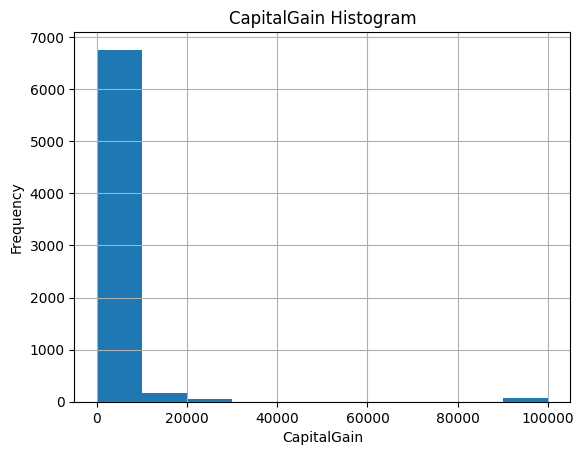

In [9]:
plt.figure(2)
data["CapitalGain"].hist()
plt.xlabel("CapitalGain")
plt.ylabel("Frequency")
plt.title("CapitalGain Histogram")
plt.show()

In [10]:
data["CapitalMissing"] = (data["CapitalGain"] == 0).astype(int)
print(f"Percentage of people with 0 in CapitalGain: {data["CapitalMissing"].mean() * 100:.2f}%")
data = data.drop(["CapitalMissing"], axis=1)
print(f"Max CapitalGain: {data["CapitalGain"].max()} ")

Percentage of people with 0 in CapitalGain: 86.49%
Max CapitalGain: 99999 


From these graphs we can see two things: we will need to use robust scaler for Age and HoursPerWeek, and that there are far too many 0's in the CapitalGain variable. We need to figure out what to do about that.


## Scaling data

### CapitalGain

The CapitalGain variable has most of it's values in 0 and little to no data in other places. This means that we want to keep that 0 value because they mean something. So if we were to scale it, we should pick a scaler that preserves the 0's. They are MinMaxScaler, MaxAbsScaler or a log.

Since most of the data is 0, the other values are considered outliers, and we should use a log scaler.

Another option is to simply use the CapitalMissing binary variable, since it indicates wether CapitalGain is a 0 or not, but in this case we will use the log scaler.


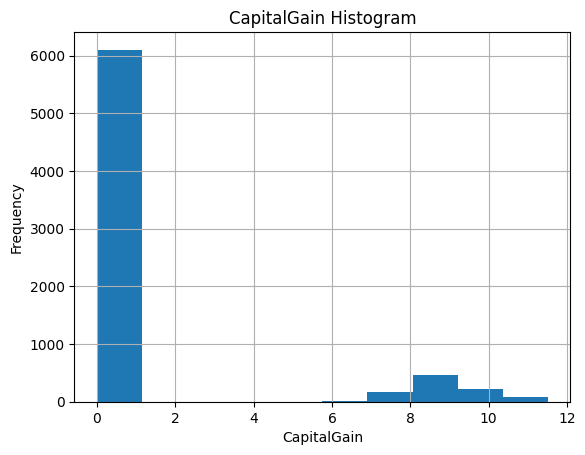

In [11]:
log_scaler = FunctionTransformer(np.log1p, validate=True)
data["CapitalGain"] = log_scaler.fit_transform(data[["CapitalGain"]])

plt.figure(3)
data["CapitalGain"].hist()
plt.xlabel("CapitalGain")
plt.ylabel("Frequency")
plt.title("CapitalGain Histogram")
plt.show()

### HoursPerWeek and Age

We've seen both of these variables' boxplots, and we know that there are many outliers. We will use the RobustScaler for these two variables


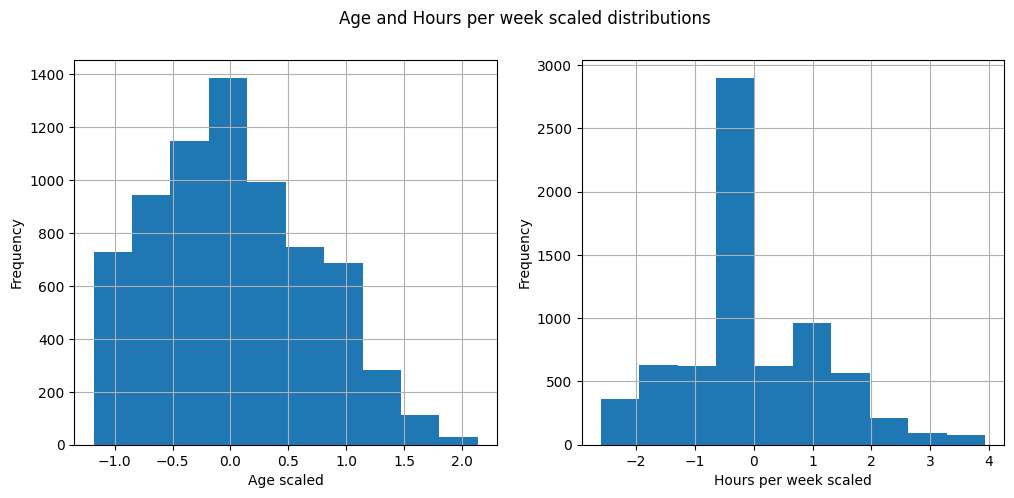

In [12]:
age_scaler = RobustScaler()
hour_scaler = RobustScaler()

data["Age"] = age_scaler.fit_transform(data[["Age"]])
data["HoursPerWeek"] = age_scaler.fit_transform(data[["HoursPerWeek"]])

plt.figure(4, figsize=(12, 5))
plt.subplot(1, 2, 1)
data["Age"].hist()
plt.xlabel("Age scaled")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
data["HoursPerWeek"].hist()
plt.xlabel("Hours per week scaled")
plt.ylabel("Frequency")

plt.suptitle("Age and Hours per week scaled distributions")
plt.show()

## Categorical variables

We have 4 categorical variables: Education, MaritalStatus, Relationship, and Gender. Education has EducationNum as it's Ordinal translation, so we will drop it. The rest of the varibles will use One-Hot encoder. Since this dataset asumes only 2 genders, we will use drop the first for that one. The rest may bring unknown values.


## Pipelines

We will implement a preproccesing pipeline to prepare the data for the rest of the notebook


In [13]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
robust_features = ["Age", "HoursPerWeek", "EducationNum"]
log_features = ["CapitalGain"]
categorical_features = ["MaritalStatus", "Relationship", "Gender"]
drop_features = ["Education"]


def log_df(X):
    X = np.log1p(X)
    return pd.DataFrame(X, columns=["CapitalGain"])


log_pipeline = make_pipeline(
    FunctionTransformer(log_df, validate=True),
    StandardScaler()
)

preproccesor = ColumnTransformer(
    transformers=[
        ("rob", RobustScaler(), robust_features),
        ("log", log_pipeline, log_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False), categorical_features),
        ("drop", "drop", drop_features)
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("preproccesor", preproccesor)
])
pipe.set_output(transform="pandas")

Pipeline(steps=[('preproccesor',
                 ColumnTransformer(transformers=[('rob', RobustScaler(),
                                                  ['Age', 'HoursPerWeek',
                                                   'EducationNum']),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_df at 0x77853f4528e0>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CapitalGain']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MaritalStatus',
                                                   'Relationship', 'Gender']),
                                                 ('drop', 'drop',
                                                  ['Education'])]))])

In [ ]:
def read_data() -> pd.DataFrame:
    try:
        data = pd.read_csv("/content/drive/MyDrive/data-even.csv")
    except FileNotFoundError:
        data = pd.read_csv("./data-even.csv")
    data[["Education", "MaritalStatus", "Relationship", "Gender"]] = data[["Education", "MaritalStatus", "Relationship", "Gender"]].map(lambda x: x.strip())
    data = data.drop_duplicates().reset_index(drop=True)
    return data


data = read_data()
data = pipe.fit_transform(data)
data.head()

rob__Age  rob__HoursPerWeek  rob__EducationNum  log__CapitalGain  \
0 -0.181818           0.000000               0.75          2.108768   
1  0.318182          -1.800000               0.75         -0.391832   
2  0.409091           0.333333              -0.25         -0.391832   
3 -0.590909           0.000000               0.75         -0.391832   
4 -0.818182          -0.333333              -0.25         -0.391832   

   cat__MaritalStatus_Divorced  cat__MaritalStatus_Married-AF-spouse  \
0                          0.0                                   0.0   
1                          0.0                                   0.0   
2                          0.0                                   0.0   
3                          0.0                                   0.0   
4                          0.0                                   0.0   

   cat__MaritalStatus_Married-civ-spouse  \
0                                    0.0   
1                                    1.0   
2                                    1.0   
3                                    1.0   
4                                    0.0   

   cat__MaritalStatus_Married-spouse-absent  cat__MaritalStatus_Never-married  \
0                                       0.0                               1.0   
1                                       0.0                               0.0   
2                                       0.0                               0.0   
3                                       0.0                               0.0   
4                                       0.0                               1.0   

   cat__MaritalStatus_Separated  cat__MaritalStatus_Widowed  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   

   cat__Relationship_Husband  cat__Relationship_Not-in-family  \
0                        0.0                              1.0   
1                        1.0                              0.0   
2                        1.0                              0.0   
3                        1.0                              0.0   
4                        0.0                              0.0   

   cat__Relationship_Other-relative  cat__Relationship_Own-child  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          1.0   

   cat__Relationship_Unmarried  cat__Relationship_Wife  cat__Gender_Male  
0                          0.0                     0.0               1.0  
1                          0.0                     0.0               1.0  
2                          0.0                     0.0               1.0  
3                          0.0                     0.0               1.0  
4                          0.0                     0.0               1.0

# Hierarchical Clustering

We are going to use the known agglomerative clustering algorithms first, and then compare their dendograms.


In [16]:
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
data = read_data()
data = pipe.transform(data)

In [17]:
linkages = ["ward", "complete", "average", "single"]

dendograms = list()

for method in linkages:
    dendograms.append(linkage(data, method=method))

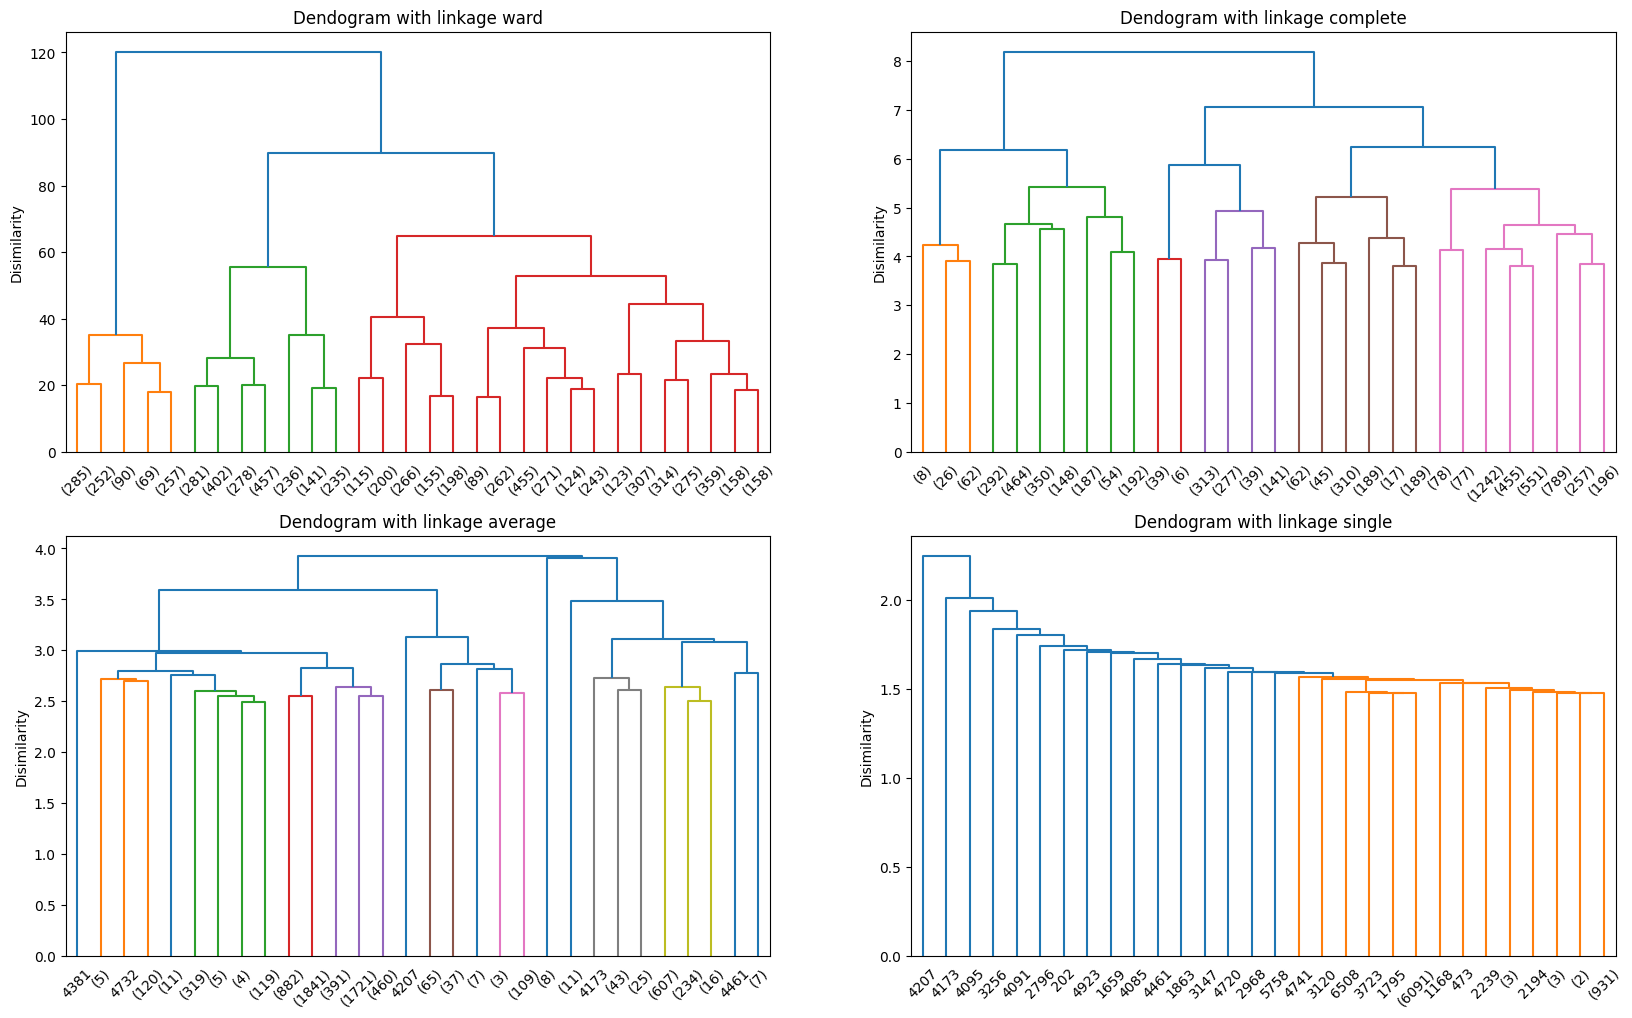

In [18]:
plt.figure(figsize=(20, 12))
for i, linked_matrix in enumerate(dendograms):
    plt.subplot(2, 2, i + 1)
    dendrogram(
        linked_matrix,
        truncate_mode="lastp",
        p=30,
        show_leaf_counts=True
    )
    plt.title(f"Dendogram with linkage {linkages[i]}")
    plt.ylabel("Disimilarity")

plt.show()

The next step is choosing a number of clusters (`K`) for each of the linkage methods. We will do this by looking at the dendograms.

The following linkages were picked based off of the disimilarities:

- **ward:** 3
- **complete:** 3
- **average:** 2
- **single:** 2

After seeing the dendograms, we pick the ward method with 3 clusters, since it seems to be the one that best separates the data.


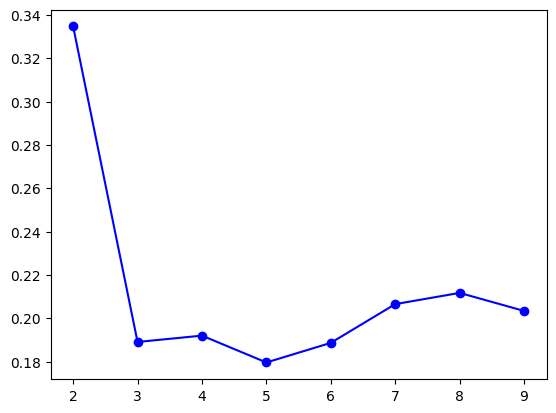

In [19]:
# check ward k values
scores = []
for k_val in range(2, 10):
    clusters = AgglomerativeClustering(n_clusters=k_val, linkage="ward").fit_predict(data)
    score = silhouette_score(data, clusters)
    scores.append(score)
plt.plot(range(2, 10), scores, 'bo-')
plt.show()

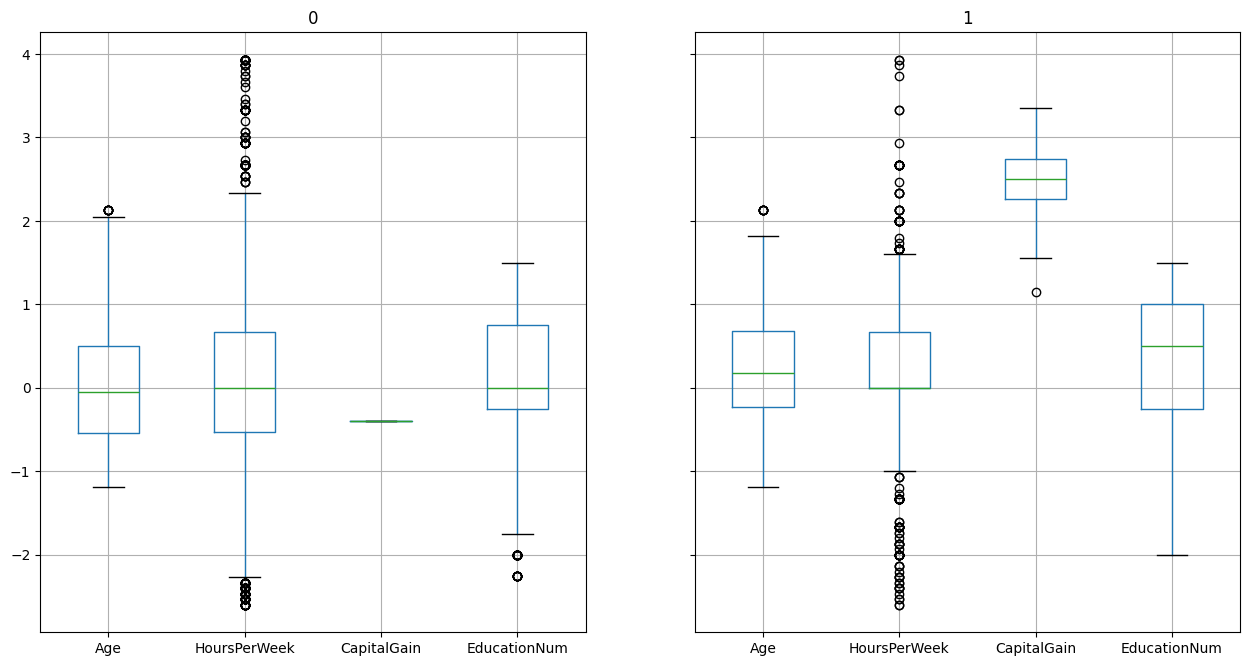

In [20]:
numeric_cols = ["Age", "HoursPerWeek", "CapitalGain", "EducationNum"]
data2 = read_data()
data2: pd.DataFrame = pipe.transform(data2)
data2 = data2.rename(columns=lambda c: c.split("__")[-1])
data2.columns = data2.columns.str.replace("MaritalStatus", "MS", regex=False)
data2.columns = data2.columns.str.replace("Relationship", "R", regex=False)
data2["clusters"] = AgglomerativeClustering(n_clusters=2, linkage="ward").fit_predict(data2)
grouped_clust = data2.groupby("clusters")
grouped_clust[numeric_cols].boxplot(figsize=(15, 8))

plt.show()

We can see that the two clusters are separated mainly thanks to CapitalGain


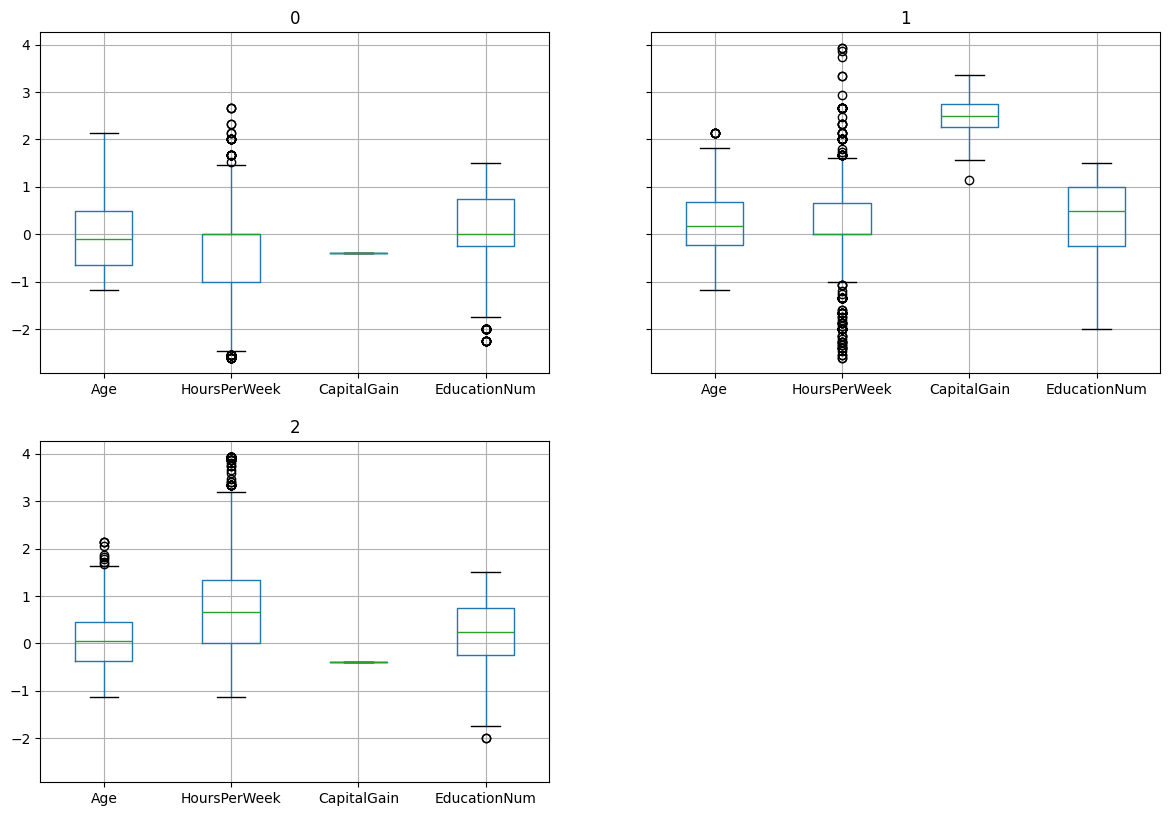

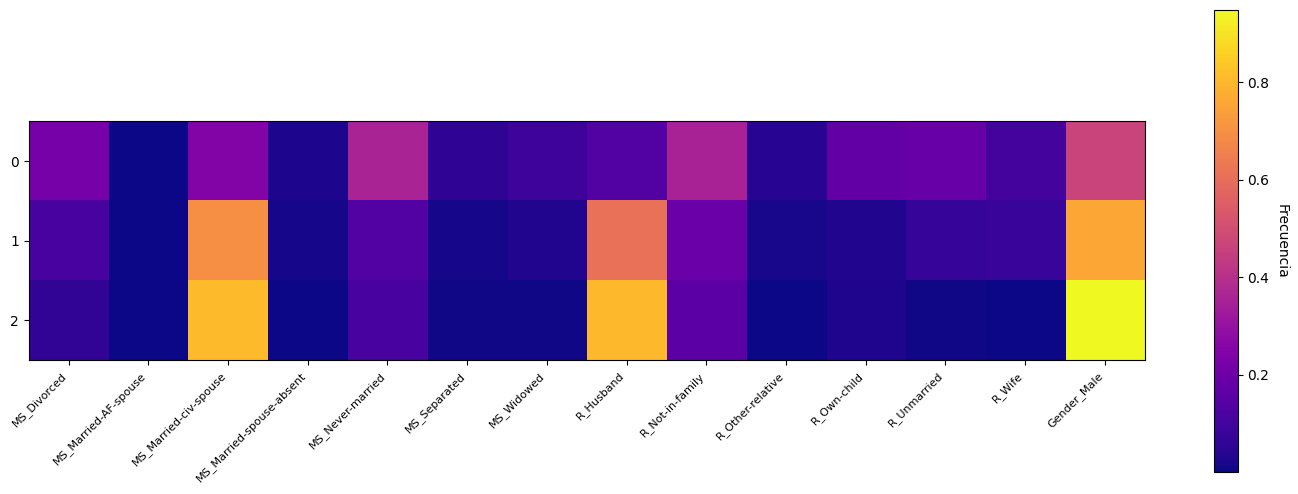

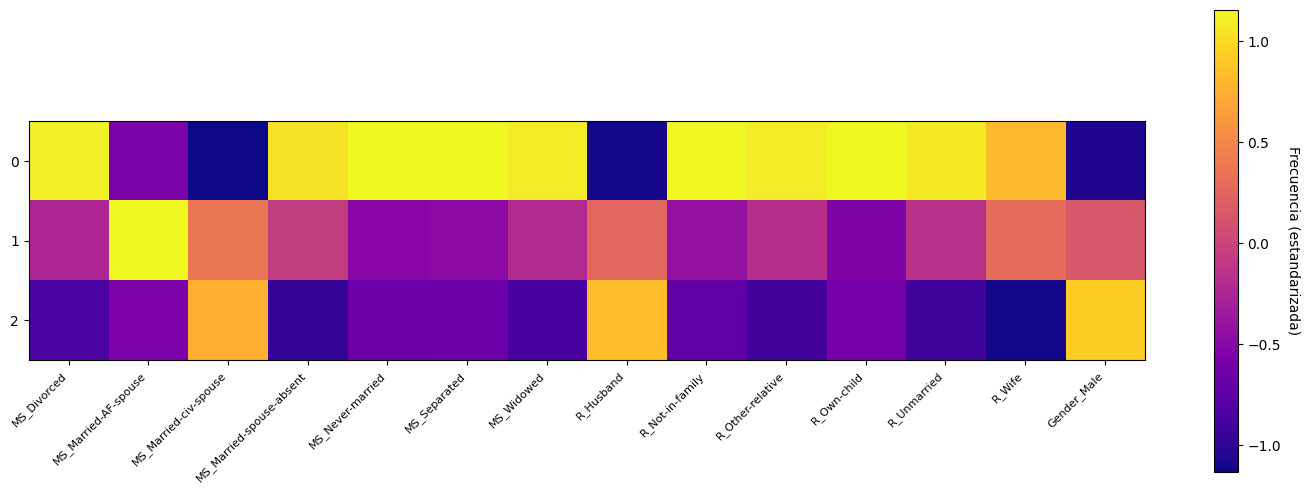

MS_Divorced  MS_Married-AF-spouse  MS_Married-civ-spouse  \
clusters                                                             
0            0.220776              0.000982               0.252456   
1            0.111228              0.002099               0.694648   
2            0.063547              0.000985               0.808374   

          MS_Married-spouse-absent  MS_Never-married  MS_Separated  \
clusters                                                             
0                         0.023821          0.356336      0.059430   
1                         0.012592          0.134313      0.012592   
2                         0.003448          0.110837      0.006897   

          MS_Widowed  R_Husband  R_Not-in-family  R_Other-relative  \
clusters                                                             
0           0.086198   0.135806         0.354862          0.044695   
1           0.032529   0.608604         0.189927          0.016789   
2           0.005911   0.805911         0.156158          0.000985   

          R_Own-child  R_Unmarried    R_Wife  Gender_Male  
clusters                                                   
0            0.172151     0.186395  0.106090     0.465619  
1            0.032529     0.074502  0.077650     0.757608  
2            0.029064     0.006897  0.000985     0.948276

MS_Divorced  MS_Married-AF-spouse  MS_Married-civ-spouse  \
clusters                                                             
0            1.103055             -0.579604              -1.132850   
1           -0.255806              1.154698               0.372808   
2           -0.847250             -0.575093               0.760042   

          MS_Married-spouse-absent  MS_Never-married  MS_Separated  \
clusters                                                             
0                         1.032326          1.150358      1.149053   
1                        -0.068137         -0.488536     -0.475744   
2                        -0.964189         -0.661822     -0.673309   

          MS_Widowed  R_Husband  R_Not-in-family  R_Other-relative  \
clusters                                                             
0           1.091846  -1.106302         1.140048          1.078599   
1          -0.220494   0.266669        -0.411221         -0.182273   
2          -0.871352   0.839633        -0.728827         -0.896326   

          R_Own-child  R_Unmarried    R_Wife  Gender_Male  
clusters                                                   
0            1.154440     1.071428  0.818822    -1.062201  
1           -0.555997    -0.162845  0.295677     0.138931  
2           -0.598443    -0.908583 -1.114498     0.923270

Age  HoursPerWeek  EducationNum  CapitalGain  MS_Divorced  \
0 -0.181818      0.000000          0.75     2.108768          0.0   
1  0.318182     -1.800000          0.75    -0.391832          0.0   
2  0.409091      0.333333         -0.25    -0.391832          0.0   
3 -0.590909      0.000000          0.75    -0.391832          0.0   
4 -0.818182     -0.333333         -0.25    -0.391832          0.0   

   MS_Married-AF-spouse  MS_Married-civ-spouse  MS_Married-spouse-absent  \
0                   0.0                    0.0                       0.0   
1                   0.0                    1.0                       0.0   
2                   0.0                    1.0                       0.0   
3                   0.0                    1.0                       0.0   
4                   0.0                    0.0                       0.0   

   MS_Never-married  MS_Separated  MS_Widowed  R_Husband  R_Not-in-family  \
0               1.0           0.0         0.0        0.0              1.0   
1               0.0           0.0         0.0        1.0              0.0   
2               0.0           0.0         0.0        1.0              0.0   
3               0.0           0.0         0.0        1.0              0.0   
4               1.0           0.0         0.0        0.0              0.0   

   R_Other-relative  R_Own-child  R_Unmarried  R_Wife  Gender_Male  clusters  
0               0.0          0.0          0.0     0.0          1.0         1  
1               0.0          0.0          0.0     0.0          1.0         0  
2               0.0          0.0          0.0     0.0          1.0         2  
3               0.0          0.0          0.0     0.0          1.0         2  
4               0.0          1.0          0.0     0.0          1.0         0

In [111]:
from IPython.display import display

numeric_cols = ["Age", "HoursPerWeek", "CapitalGain", "EducationNum"]

data2 = read_data()
data2: pd.DataFrame = pipe.transform(data2)
data2 = data2.rename(columns=lambda c: c.split("__")[-1])
data2.columns = data2.columns.str.replace("MaritalStatus", "MS", regex=False)
data2.columns = data2.columns.str.replace("Relationship", "R", regex=False)
clusters = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(data2)
hclusters = clusters
data2["clusters"] = clusters
clustered_data = data2.groupby("clusters")
clustered_data[numeric_cols].boxplot(figsize=(14, 10))


def print_heatmap(clusters, norm: bool = False):
    cluster_labels = np.unique(clusters)
    data = read_data()
    data: pd.DataFrame = pipe.transform(data)
    data = data.rename(columns=lambda c: c.split("__")[-1])
    data.columns = data.columns.str.replace("MaritalStatus", "MS", regex=False)
    data.columns = data.columns.str.replace("Relationship", "R", regex=False)
    data["clusters"] = clusters
    columnas = [x for x in data2.columns if x not in numeric_cols and x != "clusters"]

    clustered_data = data.groupby("clusters")

    cat_frecs = clustered_data[columnas]
    cat_frecs = cat_frecs.sum()/cat_frecs.count()
    if norm:
        cat_frecs = (cat_frecs - cat_frecs.mean()) / cat_frecs.std()

    fig, ax = plt.subplots(figsize=(18, 6))
    im = ax.imshow(cat_frecs, cmap='plasma')
    ax.set_xticks(np.arange(len(columnas)))
    ax.set_xticklabels(columnas)
    ax.set_yticks(np.arange(cluster_labels.shape[0]), labels=cluster_labels)
    cbar = ax.figure.colorbar(im, ax=ax)
    if norm:
        cbar.ax.set_ylabel("Frecuencia (estandarizada)", rotation=-90, va="bottom")
    else:
        cbar.ax.set_ylabel("Frecuencia", rotation=-90, va="bottom")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)

    plt.show()
    return cat_frecs


cat_frecs = print_heatmap(clusters)
norm_frecs = print_heatmap(clusters, norm=True)
display(cat_frecs)
display(norm_frecs)
display(data2.head())

In [22]:
data2["CapitalGain"].shape

(7055,)

In [23]:
import plotly.graph_objects as go
import plotly.io as pio

try:
    import google.colab
    pio.renderers.default = 'colab'
    print("Entorno detectado: Google Colab. Renderizador configurado como 'colab'.")
except ImportError:
    pio.renderers.default = 'notebook'
    print("Entorno detectado: Local (jupyter). Renderizador configurado como 'notebook'.")


variables = ["CapitalGain", "HoursPerWeek", "MS_Married-civ-spouse"]
for variable in variables:
    if (np.unique(data2[variable]).shape[0] == 2):
        dispersion = (np.random.rand(data2[variable].shape[0]) - 0.5)/2
        data2[variable] = data2[variable] + dispersion

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=data2[variables[0]],
    y=data2[variables[1]],
    z=data2[variables[2]],
    opacity=0.7,
    mode='markers',
    marker=dict(size=5, color=data2["clusters"], colorscale='Viridis', showscale=True),
    name='Data'
))

fig.update_layout(
    scene=dict(
        xaxis_title=variables[0],
        yaxis_title=variables[1],
        zaxis_title=variables[2],
    ),
    title='Cluster Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

Entorno detectado: Local (jupyter). Renderizador configurado como 'notebook'.


We can see 3 tendencies, first the one that looks most separated is the one determined by a high CapitalGain, while the other two have low capital gain but are separated mainly because of their marital status and relationships, we first now have to confirm whether the furthest cluster is, in fact the high CapitalGain


# Partitional Clustering

We will implement K-Means, with clusters from 2 to 10 (more than that seems too much). Then, we will use the elbow and silhouette coefficients to choose the number of clusters. Finally, we will analyze the silhouette scores for the chosen `K`


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

data = read_data()
X: pd.DataFrame = pipe.transform(data)

In [25]:
inertia_values = []
silhouette_values = []
K_range = range(1, 11)  # From 2 to 10

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")

    labels = kmeans.fit_predict(X)

    inertia_values.append(kmeans.inertia_)

    if K >= 2:
        silhouette_values.append(silhouette_score(X, labels))

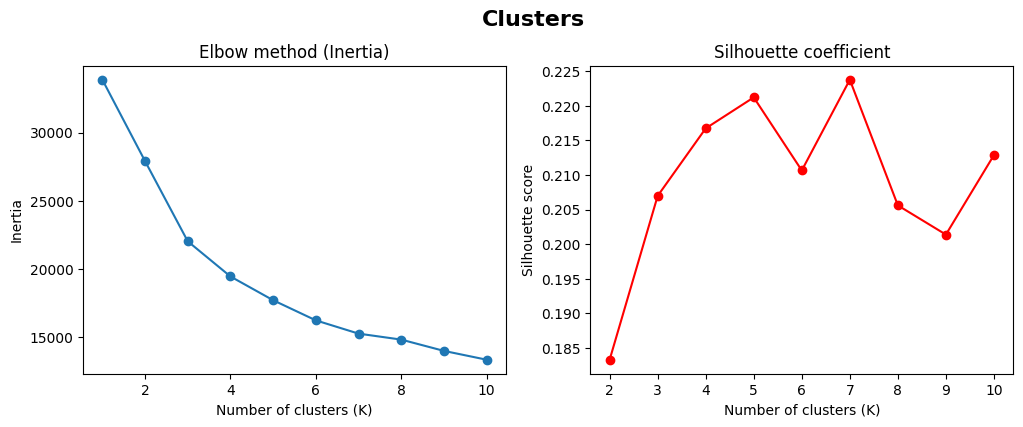

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Clusters", fontweight="bold", y=1.02, fontsize=16)

# Inertia
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia_values, marker="o")
plt.title("Elbow method (Inertia)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")

# Silhoutte
plt.subplot(1, 2, 2)
plt.plot(K_range[1:], silhouette_values, marker="o", color="red")
plt.title("Silhouette coefficient")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.show()

We can see that, differently from hierarchical clustering, the elbow method suggests 4 clusters, while the silhouette method suggests 5 clusters. We will pick 4, following Ockham's razor.


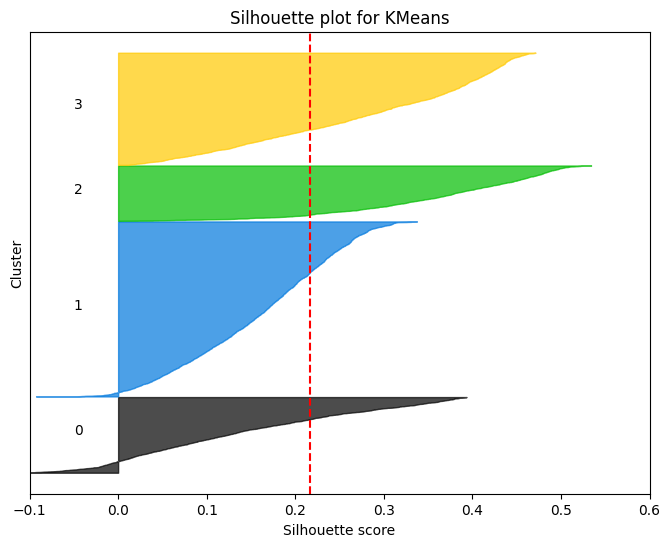

In [27]:
K = 4

model = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = model.fit_predict(X)
silhouette_values = silhouette_samples(X, labels)
silhouette_avg = silhouette_score(X, labels)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 0

for i in range(K):
    # Extract the i-eth silhouette values
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / K)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Cluster tag
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax.set_title("Silhouette plot for KMeans")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xlim([-0.1, 0.6])
plt.show()

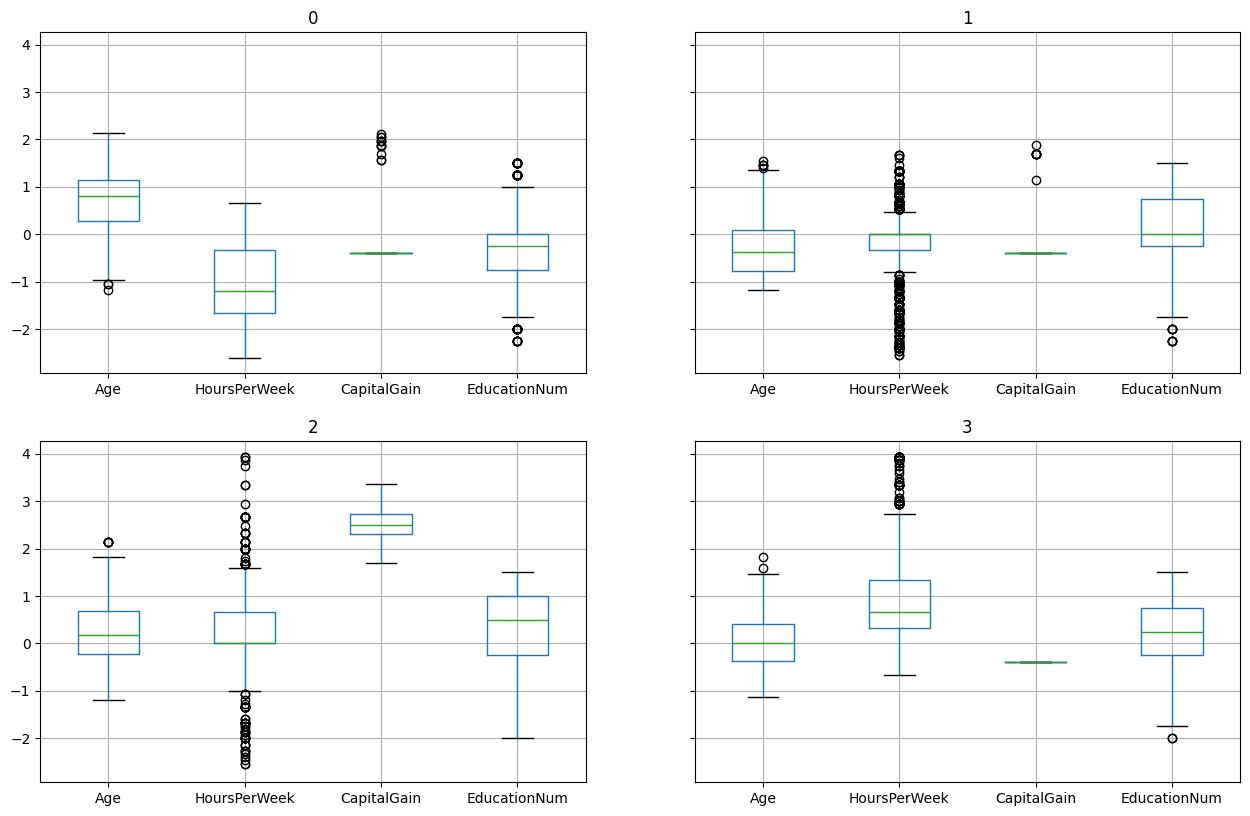

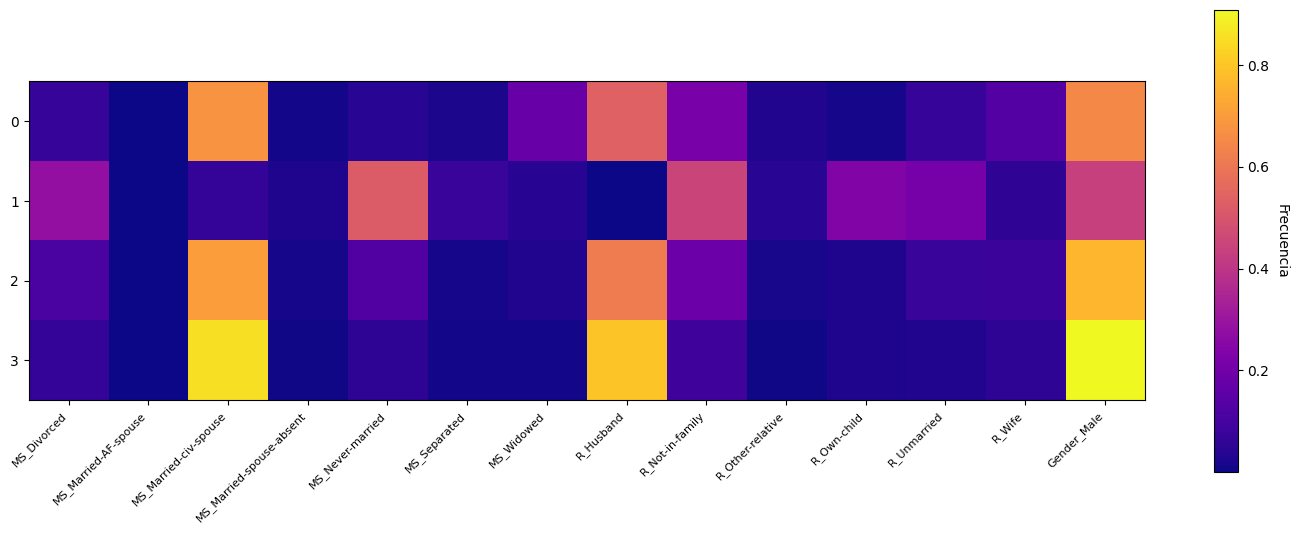

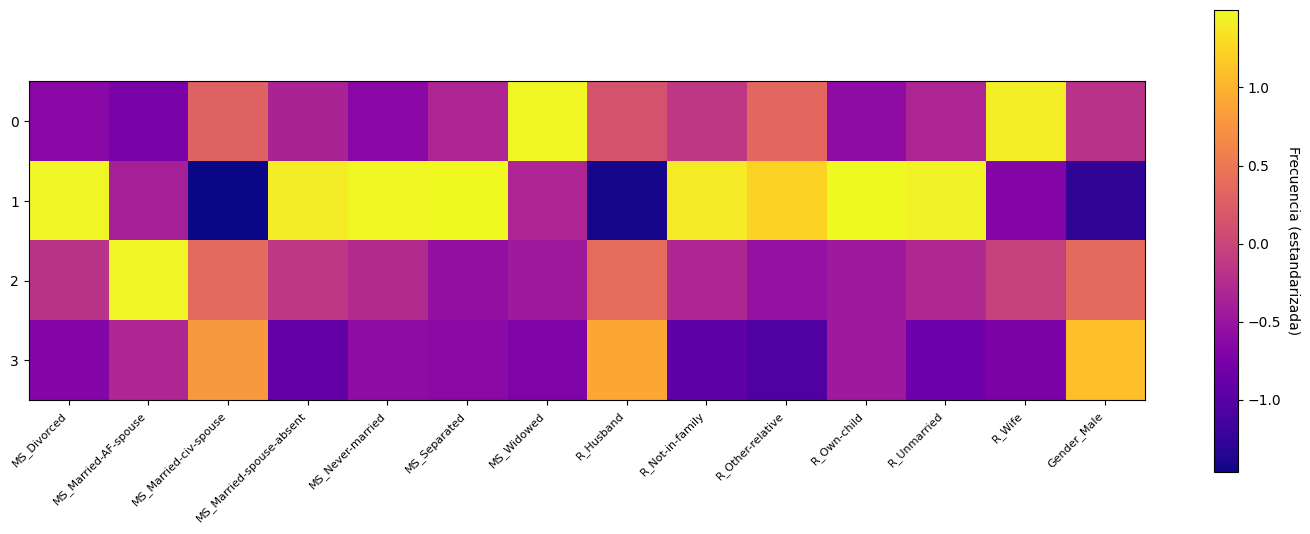

MS_Divorced  MS_Married-AF-spouse  MS_Married-civ-spouse  \
clusters                                                             
0            0.068128              0.000783               0.679718   
1            0.277439              0.001016               0.062669   
2            0.112540              0.002144               0.705252   
3            0.064976              0.001057               0.855784   

          MS_Married-spouse-absent  MS_Never-married  MS_Separated  \
clusters                                                             
0                         0.010963          0.043853      0.018794   
1                         0.026762          0.519309      0.072493   
2                         0.012862          0.125402      0.011790   
3                         0.005811          0.051770      0.010037   

          MS_Widowed  R_Husband  R_Not-in-family  R_Other-relative  \
clusters                                                             
0           0.177760   0.536413         0.214565          0.030540   
1           0.040312   0.000339         0.449526          0.046070   
2           0.030011   0.617363         0.187567          0.015005   
3           0.010565   0.796091         0.088220          0.005811   

          R_Own-child  R_Unmarried    R_Wife  Gender_Male  
clusters                                                   
0            0.012529     0.071261  0.134691     0.650744  
1            0.236789     0.212398  0.054878     0.433266  
2            0.026795     0.073955  0.079314     0.764202  
3            0.026941     0.030111  0.052826     0.908611

MS_Divorced  MS_Married-AF-spouse  MS_Married-civ-spouse  \
clusters                                                             
0           -0.625416             -0.767865               0.296044   
1            1.464317             -0.384293              -1.462767   
2           -0.182014              1.470218               0.368825   
3           -0.656887             -0.318059               0.797897   

          MS_Married-spouse-absent  MS_Never-married  MS_Separated  \
clusters                                                             
0                        -0.350342         -0.625406     -0.319147   
1                         1.414508          1.480038      1.487796   
2                        -0.138253         -0.264285     -0.554831   
3                        -0.925913         -0.590347     -0.613817   

          MS_Widowed  R_Husband  R_Not-in-family  R_Other-relative  \
clusters                                                             
0           1.480325   0.142684        -0.133354          0.349122   
1          -0.318717  -1.422736         1.402267          1.225948   
2          -0.453545   0.379070        -0.309806         -0.527977   
3          -0.708063   0.900982        -0.959106         -1.047094   

          R_Own-child  R_Unmarried    R_Wife  Gender_Male  
clusters                                                   
0           -0.587884    -0.322697  1.423337    -0.191711  
1            1.497035     1.451508 -0.670159    -1.275732  
2           -0.455255    -0.288829 -0.029199     0.373818  
3           -0.453897    -0.839982 -0.723979     1.093625

In [28]:
from IPython.display import display

numeric_cols = ["Age", "HoursPerWeek", "CapitalGain", "EducationNum"]

data2 = read_data()
data2: pd.DataFrame = pipe.transform(data2)
data2 = data2.rename(columns=lambda c: c.split("__")[-1])
data2.columns = data2.columns.str.replace("MaritalStatus", "MS", regex=False)
data2.columns = data2.columns.str.replace("Relationship", "R", regex=False)
data2["clusters"] = labels
kclusters = labels
clustered_data = data2.groupby("clusters")
clustered_data[numeric_cols].boxplot(figsize=(15, 10))


cat_frecs = print_heatmap(labels)
norm_frecs = print_heatmap(labels, norm=True)
display(cat_frecs)
display(norm_frecs)

Lets compare the silhouette graph with the analysis above.

- EducationNum: It seems to have a similar distribution across all clusters, so it does not seem to be a relevant variable for clustering.
- Age: Same as EducationNum, similar distribution across all clusters.
- HoursPerWeek: Cluster 0 has a low median (arround -1), while clusters 1 and 2 have a 0 median, and cluster 3 has a higher median (arround 0.7). While there is some overlap, clusters 0 through 2 have lower values compared to cluster 3.
- CapitalGain: Clusters 0, 1 and 3 have almost all values at 0, while cluster 2 has a much higher median (arround 2.5). This indicates that CapitalGain is a relevant variable for clustering, especially for cluster 2.

Lets look at the categorical variables:

- Cluster 0 has a high proportion of widowed individuals (MaritalStatus_Widowed) and wifes (Relationship_Wife), while low proportions on the rest.
- Cluster 1 has a high proportion of unmarried people, in other words, people who are allown (divorced, married-spouse-absent, never-married, separated, not-in-family, own-child, and unmarried), while a really low proportion of married-civilian-spouse, husband, and male.
- Cluster 2 has a high proportion of married-armed-forces, medium proportion of married-civilian-spouse, husband, and male, and really low proportion of the rest.
- Cluster 3 seems so have low proportions of everything, except for married-civilian-spouse, husband, and male, with the highest proportion of the latest.


In [29]:

variables = ["CapitalGain", "MS_Married-civ-spouse", "Age"]
for variable in variables:
    if (np.unique(data2[variable]).shape[0] == 2):
        dispersion = (np.random.rand(data2[variable].shape[0]) - 0.5)/2
        data2[variable] = data2[variable] + dispersion

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=data2[variables[0]],
    y=data2[variables[1]],
    z=data2[variables[2]],
    opacity=0.7,
    mode='markers',
    marker=dict(size=5, color=data2["clusters"], colorscale='Viridis', showscale=True),
    name='Data'
))

fig.update_layout(
    scene=dict(
        xaxis_title=variables[0],
        yaxis_title=variables[1],
        zaxis_title=variables[2],
    ),
    title='Cluster Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

# DBSCAN


In [30]:
from sklearn.cluster import DBSCAN

X: pd.DataFrame = pipe.transform(read_data())

eps_range = np.arange(0.05, 3, 0.2)
min_samples_range = range(50, 800, 50)

results = []

for eps in eps_range:
    result = []
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        n_clusters = labels.max() + 1  # because labels start at -1
        silhouette_avg = 0
        if n_clusters > 2 and n_clusters < 8:
            silhouette_avg = silhouette_score(X, labels)
        result.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "silhouette_avg": silhouette_avg
        })

    results.append(result)

In [31]:
results_df = pd.DataFrame([item for sublist in results for item in sublist])
display(results_df.sort_values(by="silhouette_avg", ascending=False).head(10))

eps  min_samples  n_clusters  silhouette_avg
120  1.65           50           3        0.277873
105  1.45           50           4        0.247948
106  1.45          100           4        0.175994
107  1.45          150           4        0.172367
108  1.45          200           4        0.171012
111  1.45          350           3        0.170180
109  1.45          250           4        0.163586
92   1.25          150           7        0.158248
112  1.45          400           3        0.155325
93   1.25          200           7        0.149638

We can see here that the best params for the DBSCAN algorithm are eps=1.65 and min_samples=70, which yield 3 clusters, with a silhouette score of 0.27. This is consistent with our previous findings using hierarchical clustering, but with a better silhouette score.


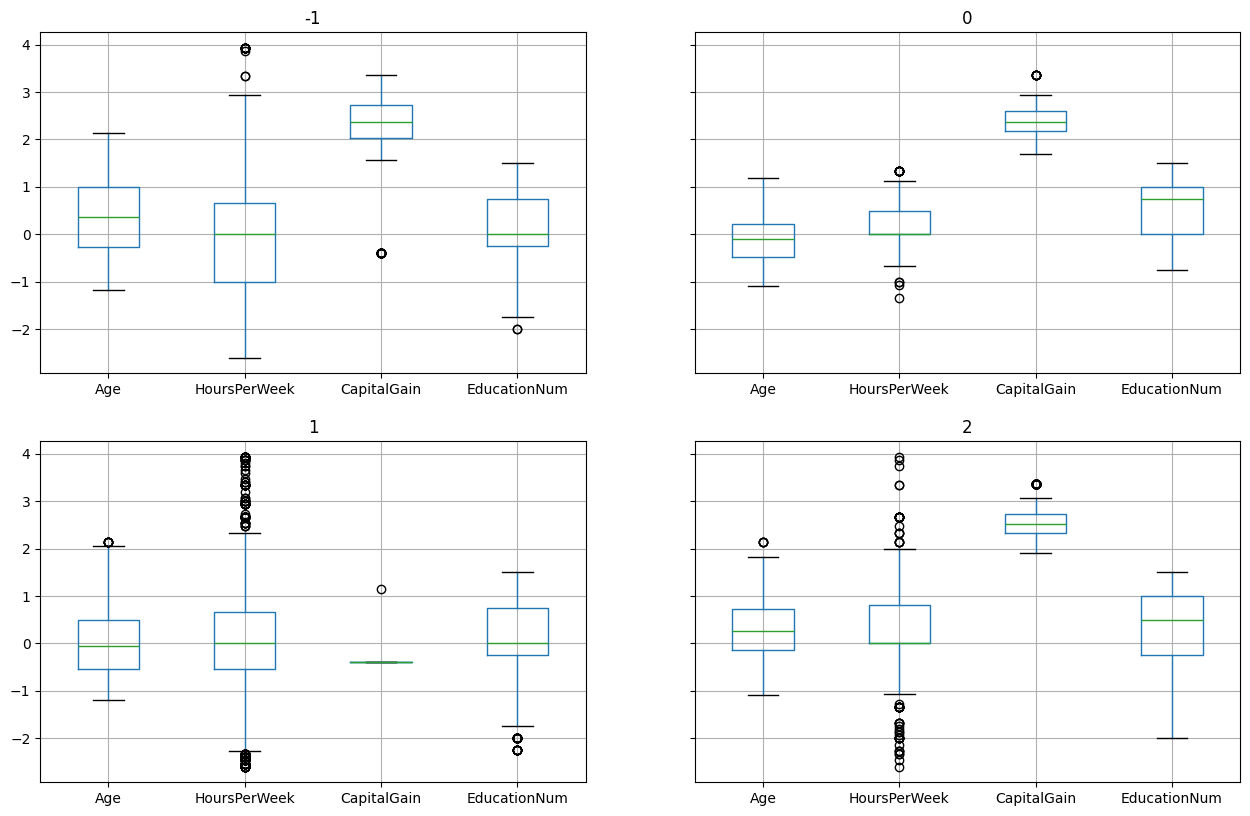

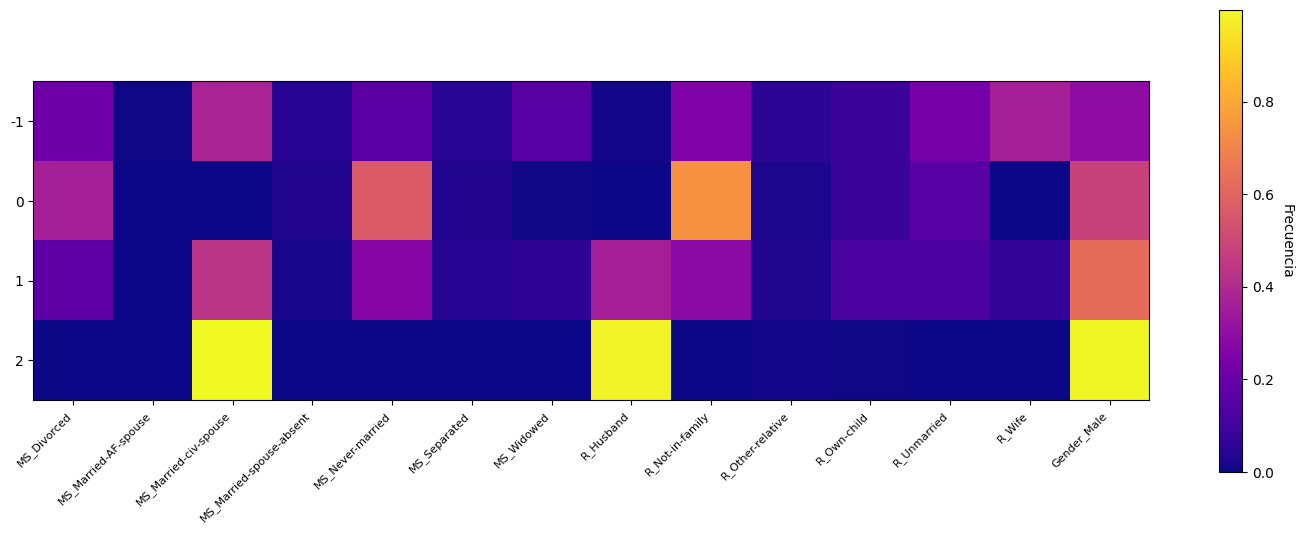

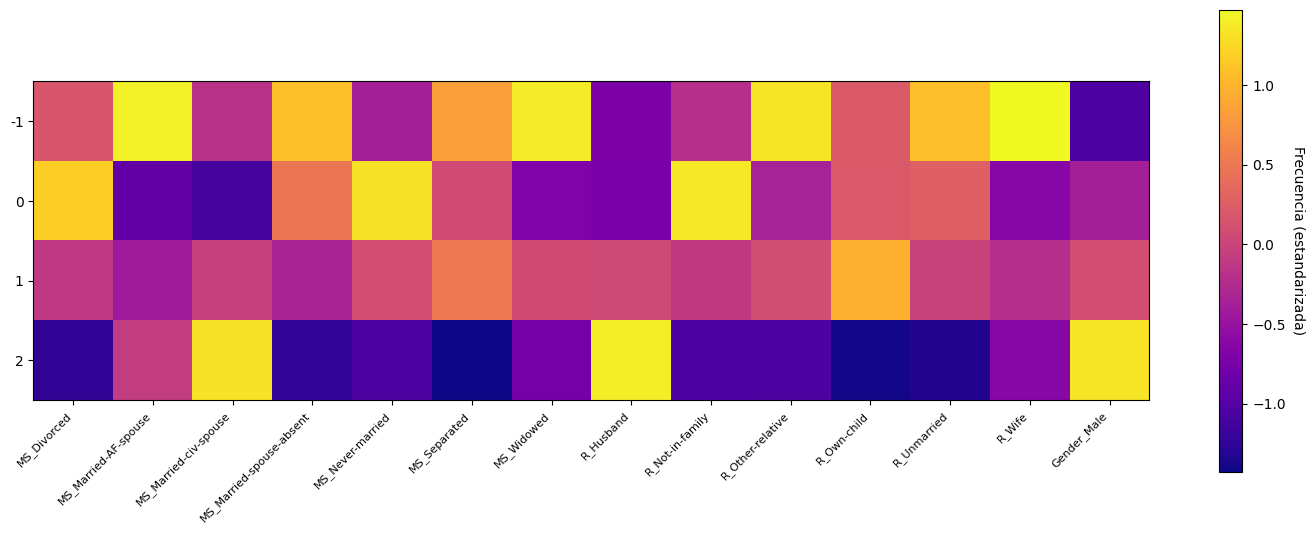

In [32]:
dbscan_final = DBSCAN(eps=1.65, min_samples=70)
labels = dbscan_final.fit_predict(X)
dblabels = labels
X = X.rename(columns=lambda c: c.split("__")[-1])
X.columns = X.columns.str.replace("MaritalStatus", "MS", regex=False)
X.columns = X.columns.str.replace("Relationship", "R", regex=False)
X["clusters"] = labels
dbclusters = labels
clustered_data = X.groupby("clusters")
clustered_data[numeric_cols].boxplot(figsize=(15, 10))


cat_frecs = print_heatmap(labels)
norm_frecs = print_heatmap(labels, norm=True)

In [33]:
variables = ["CapitalGain", "MS_Married-civ-spouse", "Gender_Male"]
for variable in variables:
    if (np.unique(X[variable]).shape[0] == 2):
        dispersion = (np.random.rand(X[variable].shape[0]) - 0.5)/2
        X[variable] = X[variable] + dispersion

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X[variables[0]],
    y=X[variables[1]],
    z=X[variables[2]],
    opacity=0.8,
    mode='markers',
    marker=dict(size=5, color=X["clusters"], colorscale='Viridis', showscale=True),
    name='Data'
))

fig.update_layout(
    scene=dict(
        xaxis_title=variables[0],
        yaxis_title=variables[1],
        zaxis_title=variables[2],
    ),
    title='Cluster Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

# Gaussian Mixtures


In [34]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

X: pd.DataFrame = pipe.transform(read_data())

In [35]:
def gmm_bic_score(estimator, X):
    return -estimator.bic(X)


def gmm_aic_score(estimator, X):
    return -estimator.aic(X)


param_grid = {
    "n_components": range(2, 11),
    "covariance_type": ["full", "tied", "diag", "spherical"]
}

grid_search_bic = GridSearchCV(
    estimator=GaussianMixture(random_state=42, max_iter=200),
    param_grid=param_grid,
    scoring=gmm_bic_score,
)

grid_search_aic = GridSearchCV(
    estimator=GaussianMixture(random_state=42, max_iter=200),
    param_grid=param_grid,
    scoring=gmm_aic_score,
)

grid_search_bic.fit(X)
grid_search_aic.fit(X)

print("Best GMM parameters (BIC):", grid_search_bic.best_params_)
print("Best BIC score:", -grid_search_bic.best_score_)
print("\nBest GMM parameters (AIC):", grid_search_aic.best_params_)
print("Best AIC score:", -grid_search_aic.best_score_)

Best GMM parameters (BIC): {'covariance_type': 'full', 'n_components': 4}
Best BIC score: -131642.4625053089

Best GMM parameters (AIC): {'covariance_type': 'full', 'n_components': 4}
Best AIC score: -135628.7714547652


We can see that the best model, scored with both BIC and AIC, is the one with 4 components and a 'full' covariance type. This is consistent with our previous findings using K-Means which also suggested 4 clusters.


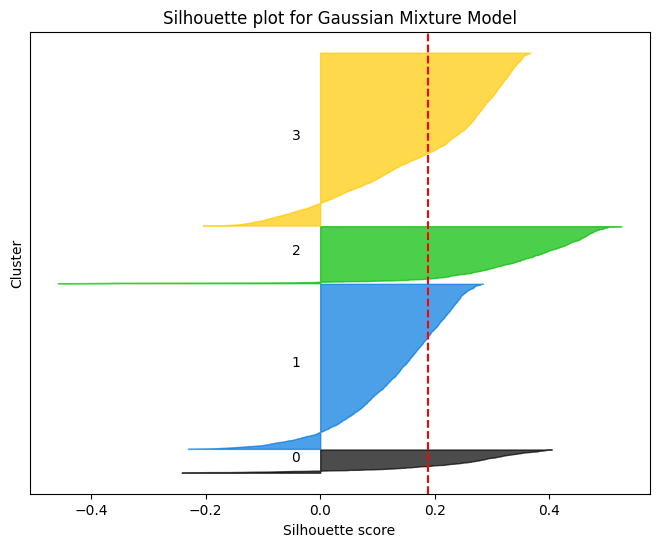

In [36]:
best_model = grid_search_bic.best_estimator_
labels = best_model.predict(X)
gmlabels = labels
K = best_model.n_components
silhouette_values = silhouette_samples(X, labels)
silhouette_avg = silhouette_score(X, labels)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 0

for i in range(K):
    # Extract the i-eth silhouette values
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / K)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Cluster tag
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax.set_title("Silhouette plot for Gaussian Mixture Model")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.show()

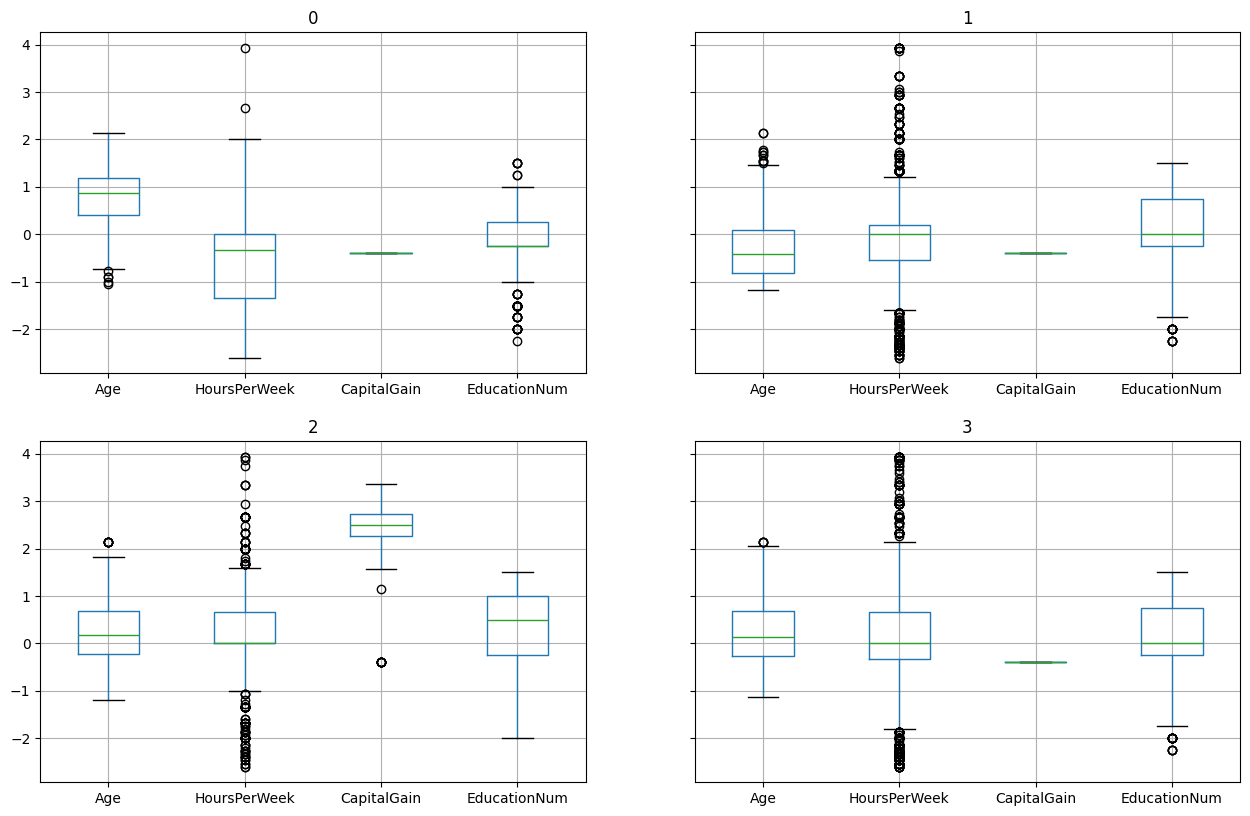

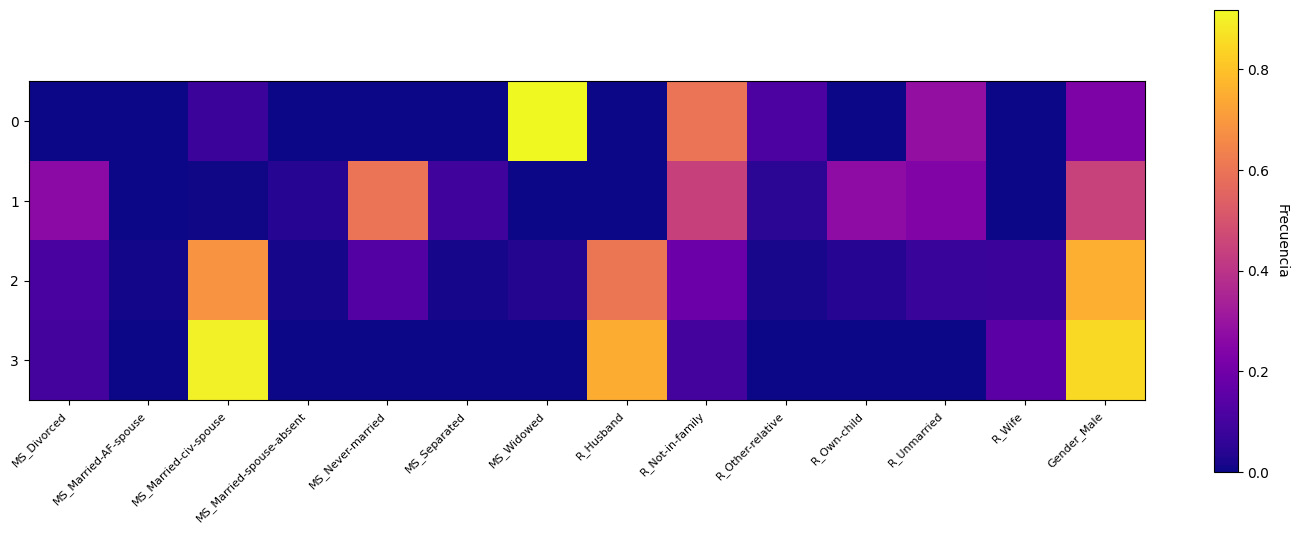

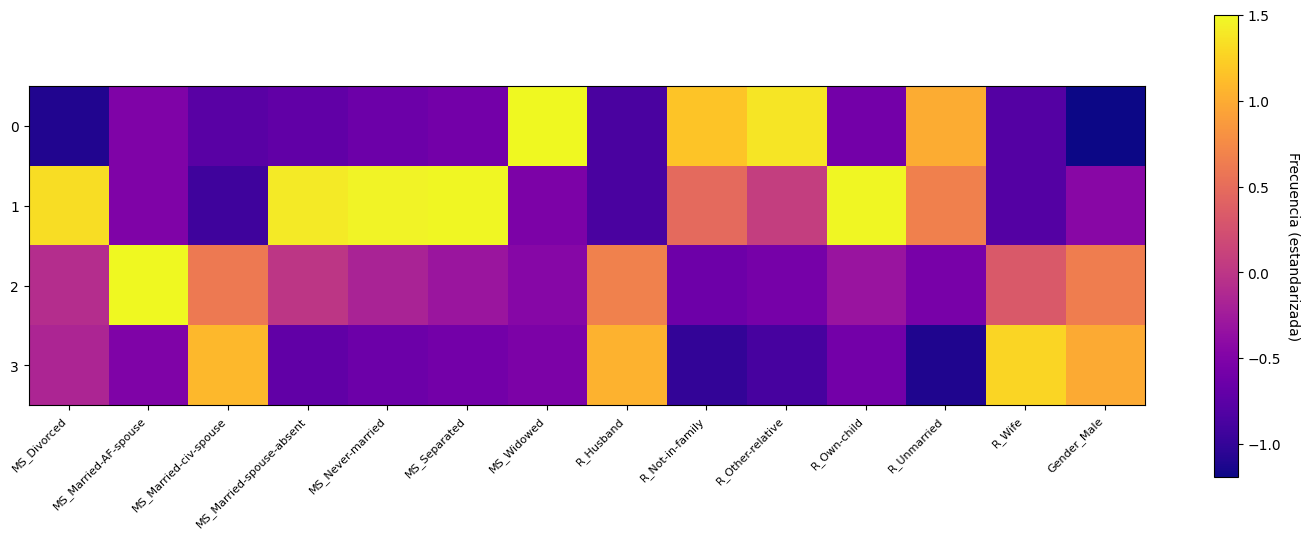

In [37]:
X = X.rename(columns=lambda c: c.split("__")[-1])
X.columns = X.columns.str.replace("MaritalStatus", "MS", regex=False)
X.columns = X.columns.str.replace("Relationship", "R", regex=False)
X["clusters"] = labels

clustered_data = X.groupby("clusters")
clustered_data[numeric_cols].boxplot(figsize=(15, 10))


cat_frecs = print_heatmap(labels)
norm_frecs = print_heatmap(labels, norm=True)

In [38]:
variables = ["CapitalGain", "MS_Married-civ-spouse", "HoursPerWeek"]
for variable in variables:
    if (np.unique(X[variable]).shape[0] == 2):
        dispersion = (np.random.rand(X[variable].shape[0]) - 0.5)/2
        X[variable] = X[variable] + dispersion

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X[variables[0]],
    y=X[variables[1]],
    z=X[variables[2]],
    opacity=0.8,
    mode='markers',
    marker=dict(size=5, color=X["clusters"], colorscale='Viridis', showscale=True),
    name='Data'
))

fig.update_layout(
    scene=dict(
        xaxis_title=variables[0],
        yaxis_title=variables[1],
        zaxis_title=variables[2],
    ),
    title='Cluster Plot',
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

# PCA


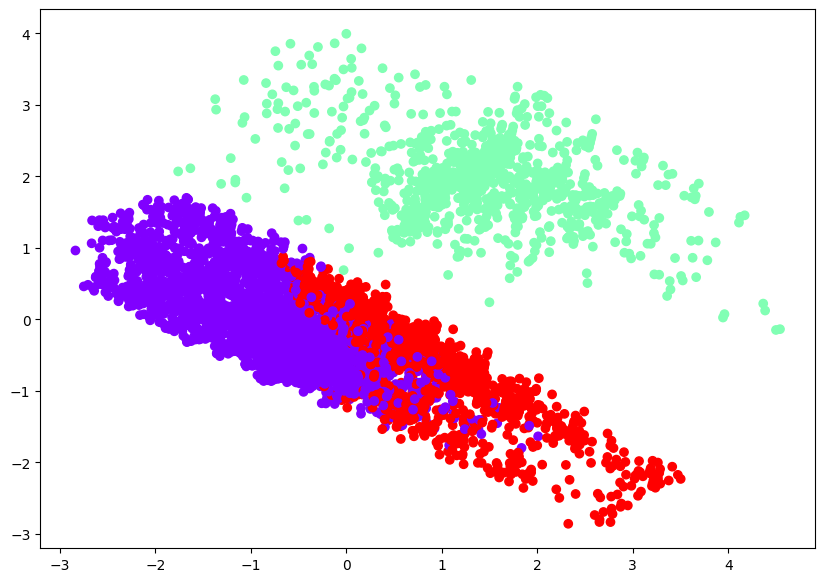

In [112]:
from sklearn.decomposition import PCA
X: pd.DataFrame = pipe.transform(read_data())
X = X.rename(columns=lambda c: c.split("__")[-1])
X.columns = X.columns.str.replace("MaritalStatus", "MS", regex=False)
X.columns = X.columns.str.replace("Relationship", "R", regex=False)
pca = PCA(n_components=3)


componentes = pca.fit_transform(X)
plt.figure(figsize=(10, 7))
plt.scatter(componentes[:, 0], componentes[:, 1], c=hclusters, cmap='rainbow')

In [116]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=X.columns
)

print("Contribución de cada variable a los Componentes Principales:")
display(loadings)

Contribución de cada variable a los Componentes Principales:


PC1       PC2       PC3
Age                       0.047177  0.249875  0.474095
HoursPerWeek              0.802514 -0.546822 -0.065090
EducationNum              0.169330  0.044252 -0.196721
CapitalGain               0.454009  0.762975 -0.413862
MS_Divorced              -0.023423 -0.044270 -0.094406
MS_Married-AF-spouse      0.000037  0.000150 -0.000578
MS_Married-civ-spouse     0.182203  0.140043  0.413605
MS_Married-spouse-absent -0.003074 -0.002707 -0.007090
MS_Never-married         -0.107495 -0.097981 -0.307359
MS_Separated             -0.012120 -0.011874 -0.015828
MS_Widowed               -0.036127  0.016639  0.011656
R_Husband                 0.197423  0.120458  0.409593
R_Not-in-family          -0.069943 -0.066851 -0.215460
R_Other-relative         -0.012750 -0.003364 -0.012192
R_Own-child              -0.064565 -0.043388 -0.118445
R_Unmarried              -0.035564 -0.026221 -0.067691
R_Wife                   -0.014601  0.019366  0.004195
Gender_Male               0.150031  0.030435  0.230564

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=componentes[:, 0],
    y=componentes[:, 1],
    z=componentes[:, 2],
    opacity=0.7,
    mode='markers',
    marker=dict(size=5, color=hclusters, colorscale='Rainbow'),
    name='Data'
))


fig.show()